# Esercizio (Consegna 16 aprile)

Usando la libreria MLLIB
 - Applicare la PCA e plottare le prime due componenti si vedono dei cluster
 - Applicare l'algoritmo KMeans (k =2 pari al numero di etichette presenti nei dati) di LMLIB sui dati originali e sul risultato della PCA e confrontare i due clustering con la misura Silhouette

In [1]:
import numpy as np
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from sklearn.datasets import load_breast_cancer
from pyspark.sql.functions import col, when
from sklearn.model_selection import train_test_split

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
print(spark.sparkContext.master)

local[*]


Carichiamo il dataset su Breast Cancer

In [3]:
breast_cancer = load_breast_cancer()

In [4]:
print(breast_cancer.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
print(breast_cancer.target_names)

['malignant' 'benign']


creiamo un dataframe a partire dal dataset

In [6]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
pd_df["target"] = breast_cancer.target
df = spark.createDataFrame(pd_df)

df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|target|
+-----------

usiamo la funzione di spark VectorAssembler per creare la colonna "features".

Questa colonna conterrà un array con tutte le feature della riga. Verrà usato durante il calcolo della PCA, previa normalizzazione.

In [8]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df = assembler.transform(df)
df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension

dividiamo in train e test

In [9]:
train_df, test_df = df.randomSplit(weights=[0.8,0.2], seed=200)

normalizziamo la colonna features usando StandardScaler di spark

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(train_df)

train_df = scaler_model.transform(train_df)
test_df = scaler_model.transform(test_df)

test_df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|wo

# PCA

applichiamo la PCA, riducendo i dati in due componenti ($k=2$) principali

In [11]:
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(train_df)

train_df = pca_model.transform(train_df)
test_df = pca_model.transform(test_df)
test_df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+--------------------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave poi

plottiamo intanto le due componenti rispetto alla ground truth.

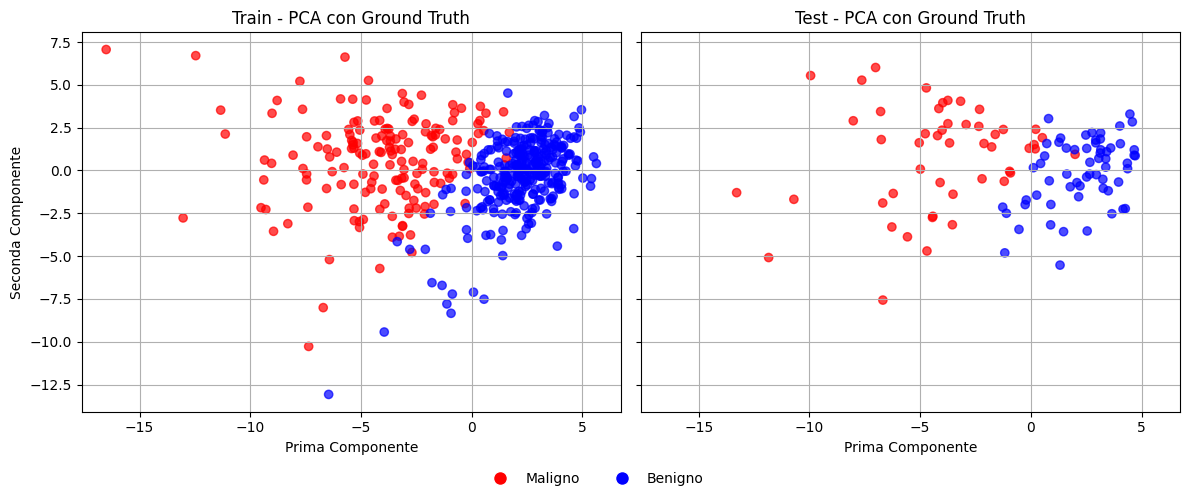

In [12]:
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

# Estrazione componenti pca
train_pd[['pca1', 'pca2']] = train_pd['pcaFeatures'].apply(lambda x: pd.Series(x.toArray()))
test_pd[['pca1', 'pca2']] = test_pd['pcaFeatures'].apply(lambda x: pd.Series(x.toArray()))

# Mappatura in colori
colors = {0: 'red', 1: 'blue'}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# --- Grafico Train ---
ax1.scatter(train_pd['pca1'], train_pd['pca2'], c=train_pd['target'].map(colors), alpha=0.7)
ax1.set_title("Train - PCA con Ground Truth")
ax1.set_xlabel("Prima Componente")
ax1.set_ylabel("Seconda Componente")
ax1.grid(True)

# --- Grafico Test ---
ax2.scatter(test_pd['pca1'], test_pd['pca2'], c=test_pd['target'].map(colors), alpha=0.7)
ax2.set_title("Test - PCA con Ground Truth")
ax2.set_xlabel("Prima Componente")
ax2.grid(True)

# Legenda
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Maligno', markersize=10, markerfacecolor='red'),
    Line2D([0], [0], marker='o', color='w', label='Benigno', markersize=10, markerfacecolor='blue'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# K-Means

applichiamo il k-means con $k=2$

In [13]:
kmeans = KMeans(k=2, seed=1, featuresCol="pcaFeatures")
model = kmeans.fit(train_df)

train_df = model.transform(train_df)
test_df = model.transform(test_df)

test_df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+--------------------+--------------------+----------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst 

invertiamo correttamente 0 e 1

In [28]:
train_df = train_df.withColumn("prediction", 1 - col("prediction"))
test_df = test_df.withColumn("prediction", 1 - col("prediction"))

In [29]:
test_df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+--------------------+--------------------+----------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst 

Valutiamo il clustering tramite il Silhouette score

In [30]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(test_df)
print(f"Silhouette K-means (k = 2): {silhouette}")

Silhouette K-means (k = 2): 0.6328250177224558


Vediamo error rate

In [31]:
errors = test_df.filter(col("target") != col("prediction")).count()
total = test_df.count()
error_rate = errors / total

print(f"Error Rate: {error_rate:.4f}")
print(f"Errors: {errors} - Total: {total}")

Error Rate: 0.0909
Errors: 10 - Total: 110


plottiamo le componenti rispetto al clustering effettuato tramite il K-means

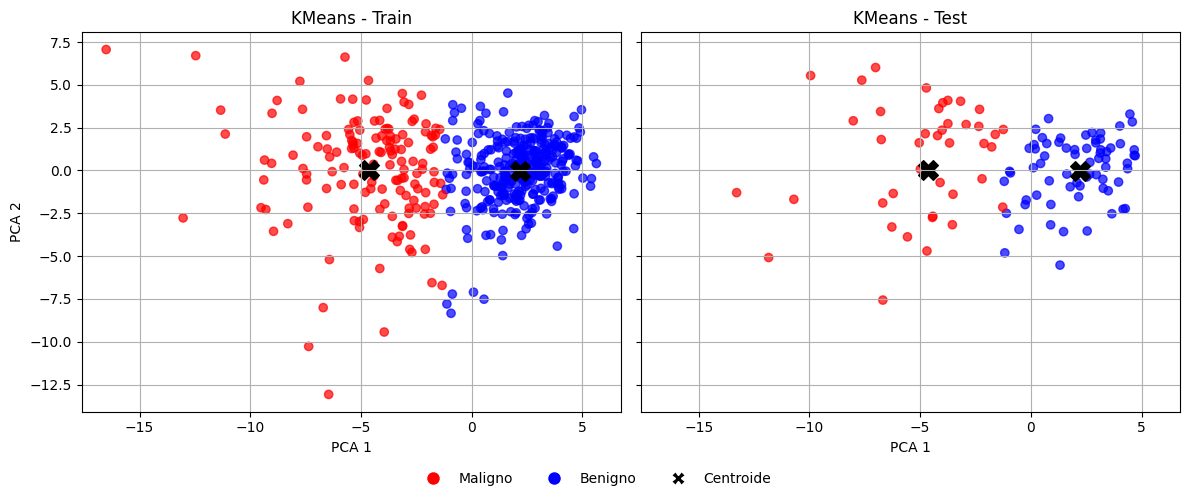

In [32]:
train_kmeans_pd = train_df.select("pcaFeatures", "prediction").toPandas()
test_kmeans_pd = test_df.select("pcaFeatures", "prediction").toPandas()

train_kmeans_pd["x"] = train_kmeans_pd["pcaFeatures"].apply(lambda v: float(v[0]))
train_kmeans_pd["y"] = train_kmeans_pd["pcaFeatures"].apply(lambda v: float(v[1]))
test_kmeans_pd["x"] = test_kmeans_pd["pcaFeatures"].apply(lambda v: float(v[0]))
test_kmeans_pd["y"] = test_kmeans_pd["pcaFeatures"].apply(lambda v: float(v[1]))

# Centroidi
centroids = model.clusterCenters()
centroids_x = [c[0] for c in centroids]
centroids_y = [c[1] for c in centroids]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# --- Train ---
ax1.scatter(train_kmeans_pd["x"], train_kmeans_pd["y"],
            c=train_kmeans_pd["prediction"].map(colors), alpha=0.7)
ax1.scatter(centroids_x, centroids_y, c='black', marker='X', s=200, label='Centroidi')
ax1.set_title("KMeans - Train")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.grid(True)

# --- Test ---
ax2.scatter(test_kmeans_pd["x"], test_kmeans_pd["y"],
            c=test_kmeans_pd["prediction"].map(colors), alpha=0.7)
ax2.scatter(centroids_x, centroids_y, c='black', marker='X', s=200, label='Centroidi')
ax2.set_title(f"KMeans - Test")
ax2.set_xlabel("PCA 1")
ax2.grid(True)

# Legenda
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Maligno', markersize=10, markerfacecolor='red'),
    Line2D([0], [0], marker='o', color='w', label='Benigno', markersize=10, markerfacecolor='blue'),
    Line2D([0], [0], marker='X', color='w', label='Centroide', markersize=10, markerfacecolor='black')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()